In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [61]:
from utils import load_mnist, minibatches, random_cycle

In [62]:
X_train, y_train, *_ = load_mnist()

In [678]:
batch_size = 100
batcher = random_cycle(X_train*2 - 1, batch_size=100)

In [763]:
def generator(input):
    with tf.variable_scope('generator'):
        input = tf.layers.dense(input, 490, activation=tf.nn.relu)
#         input = tf.layers.dense(input, 49, activation=tf.nn.relu)
        input = tf.reshape(input, (-1, 10, 7, 7))
        input = tf.layers.conv2d_transpose(input, 20, kernel_size=2, strides=2, data_format='channels_first', 
                                           activation=tf.nn.relu)
        input = tf.layers.conv2d_transpose(input, 1, kernel_size=2, strides=2, data_format='channels_first',
                                           activation=tf.nn.relu)
        input = tf.layers.conv2d(input, 1, kernel_size=1, data_format='channels_first')
        return tf.nn.tanh(input)

def discriminator(input, reuse):
    with tf.variable_scope('discriminator', reuse=reuse):
        input = tf.layers.conv2d(input, 16, kernel_size=3, data_format='channels_first', activation=tf.nn.relu)
        input = tf.layers.conv2d(input, 32, kernel_size=3, data_format='channels_first', activation=tf.nn.relu)
        input = tf.layers.max_pooling2d(input, pool_size=2, strides=2, padding='same', data_format='channels_first')

        input = tf.layers.conv2d(input, 64, kernel_size=3, data_format='channels_first', activation=tf.nn.relu)
        input = tf.layers.conv2d(input, 128, kernel_size=3, data_format='channels_first', activation=tf.nn.relu)
        input = tf.layers.max_pooling2d(input, pool_size=2, strides=2, padding='same', data_format='channels_first')

        input = tf.reshape(input, (-1, 4*4 * 128))
        input = tf.layers.dense(input, 500, activation=tf.nn.relu)
        input = tf.layers.dense(input, 100, activation=tf.nn.relu)
        input = tf.layers.dense(input, 1)
        return tf.nn.sigmoid(input)

In [764]:
sess.close()
tf.reset_default_graph()

fake_dim = 2
fake_ph = tf.placeholder(tf.float32, (None, fake_dim))
true_ph = tf.placeholder(tf.float32, (None, 1, 28, 28))

true = discriminator(true_ph, False)

fake_data = generator(fake_ph)
fake = discriminator(fake_data, True)

d_loss = tf.reduce_mean(tf.log(true) + tf.log(1 - fake))
g_loss = tf.reduce_mean(tf.log(fake))

In [765]:
d_lr = tf.placeholder(tf.float32)
g_lr = tf.placeholder(tf.float32)

d_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
d_opt = tf.train.AdamOptimizer(d_lr).minimize(-d_loss, var_list=d_params)

g_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
g_opt = tf.train.AdamOptimizer(g_lr).minimize(-g_loss, var_list=g_params)

In [766]:
sess = tf.InteractiveSession()

In [767]:
sess.run(tf.global_variables_initializer())

In [770]:
std = .3

In [771]:
d_losses, g_losses = [], []

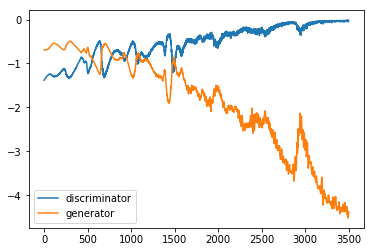

In [821]:
for i in range(500):
    x_fake = np.random.normal(scale=std, size=(batch_size, fake_dim))
    x_true = next(batcher)

    loss, _ = sess.run([d_loss, d_opt], {fake_ph: x_fake, true_ph: x_true, d_lr: 5e-6})
    d_losses.append(loss)

    x_fake = np.random.normal(scale=std, size=(batch_size, fake_dim))
    loss, _ = sess.run([g_loss, g_opt], {fake_ph: x_fake, g_lr: 1e-4})
    g_losses.append(loss)

plt.plot(d_losses, label='discriminator')
plt.plot(g_losses, label='generator')
plt.legend()

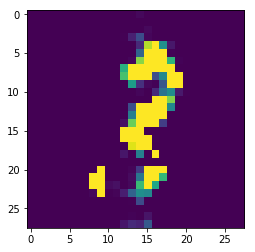

In [825]:
x_fake = np.random.normal(scale=std, size=(1, fake_dim))
z = sess.run(fake_data, {fake_ph: x_fake})
plt.imshow(z[0, 0])

In [826]:
from itertools import product

num = np.ones(2, int) * 50
shape = np.array([28, 28])
begin = np.array([-30, -30])
end = np.array([30, 30])

res = np.empty(num * shape)
step = (end - begin) / num
for coords in product(range(num[0]), range(num[1])):
    coords = np.array(coords)
    r = sess.run(fake_data, {fake_ph: [begin + coords*step]})[0, 0]
    coords *= 28
    slc = [slice(*i) for i in zip(coords, coords + shape)]
    res[slc] = r    

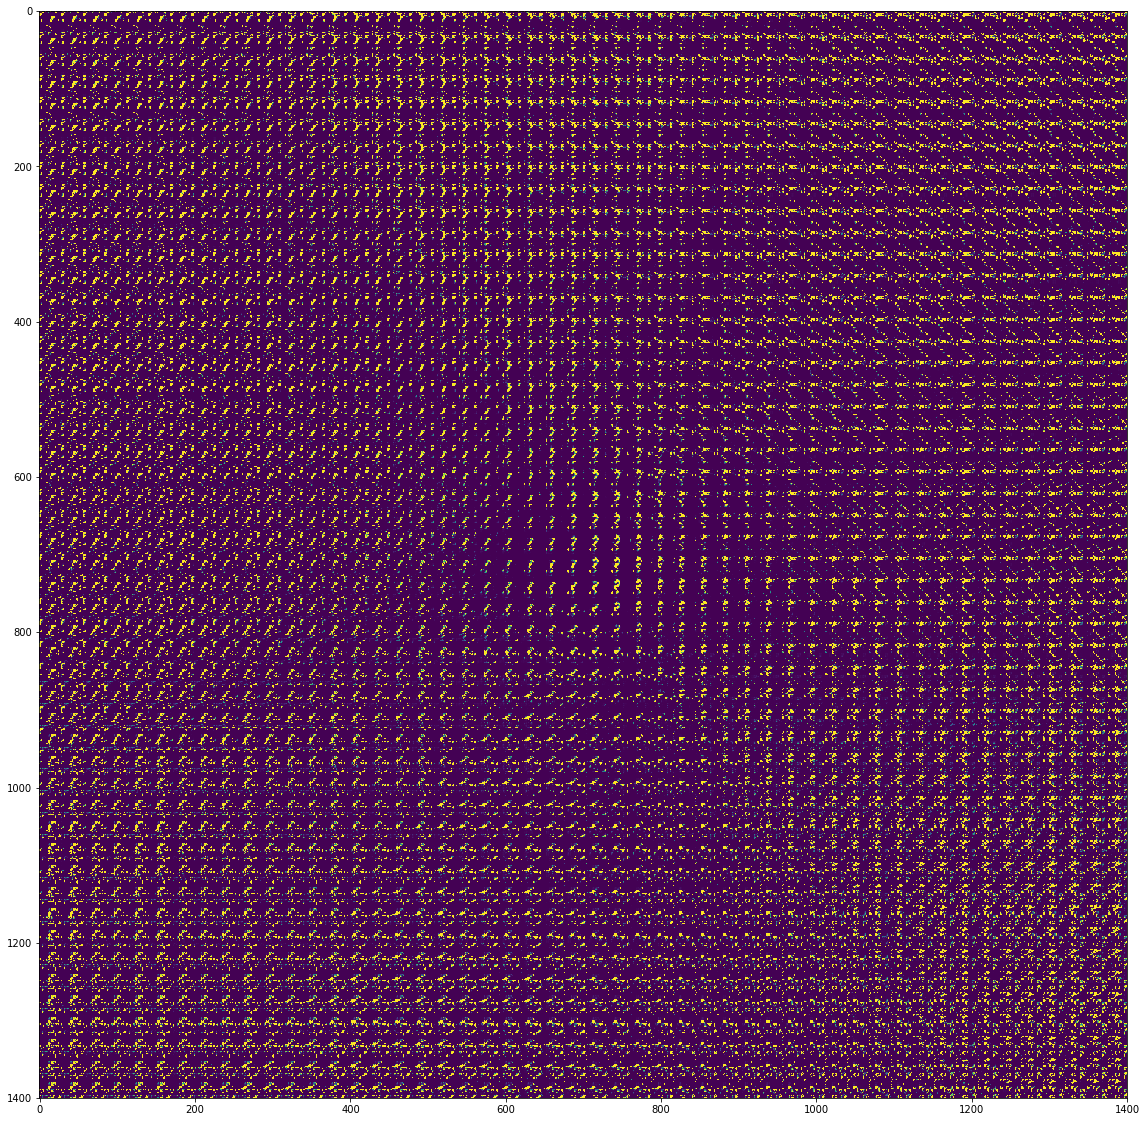

In [827]:
plt.figure(figsize=(20, 20))
plt.imshow(res)